# EDA

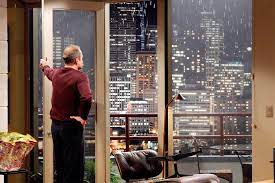

In [24]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import optbinning as op
from scipy import stats



# from matplotlib.ticker import PercentFormatter
# plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
# plt.rcParams["figure.facecolor"]= "w"
# pd.plotting.register_matplotlib_converters()

# pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('data/house_merged_clean.csv')
df.head()


,Unnamed: 0,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
0,0,7129300520,3.0,1.00,1180.0,5650.0,1.0,True,0.0,3,...,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0
1,1,6414100192,3.0,2.25,2570.0,7242.0,2.0,False,0.0,3,...,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0
2,2,5631500400,2.0,1.00,770.0,10000.0,1.0,False,0.0,3,...,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0
3,3,2487200875,4.0,3.00,1960.0,5000.0,1.0,False,0.0,5,...,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0
4,4,1954400510,3.0,2.00,1680.0,8080.0,1.0,False,0.0,3,...,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0


## Frist Hyphotesis
### Houses located near Seattle and Bellevue are generally more expensive.

<Axes: xlabel='near_belv_seattle'>

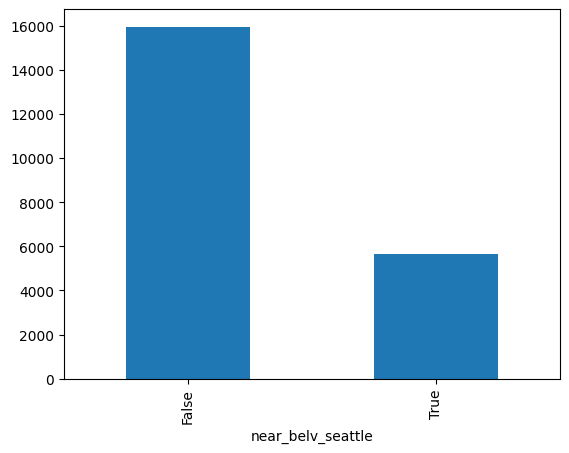

In [3]:
df['near_belv_seattle'] = (
    (df['lat'] > 47.534) & (df['lat'] < 47.6712) &
    (df['long'] < -122.101) & (df['long'] > -122.519)
)
df['near_belv_seattle'].value_counts().plot(kind='bar')

<Axes: title={'center': 'price'}, xlabel='near_belv_seattle'>

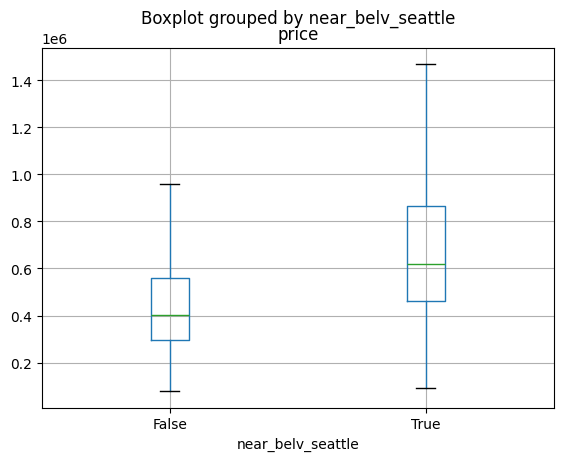

In [4]:
df.boxplot(column='price', by='near_belv_seattle', showfliers=False)

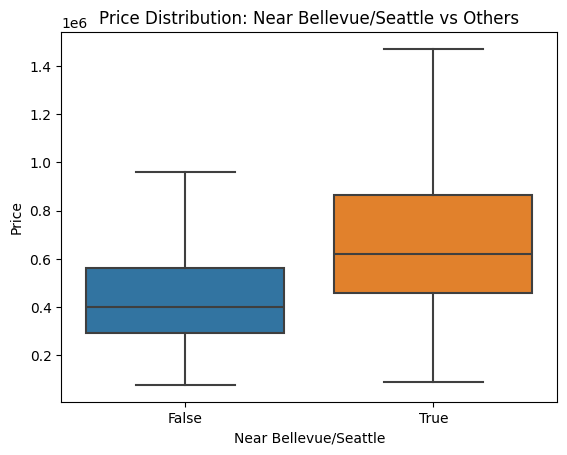

In [5]:
sns.boxplot(x='near_belv_seattle', y='price', data=df, showfliers=False)
plt.title('Price Distribution: Near Bellevue/Seattle vs Others')
plt.xlabel('Near Bellevue/Seattle')
plt.ylabel('Price')
plt.show()

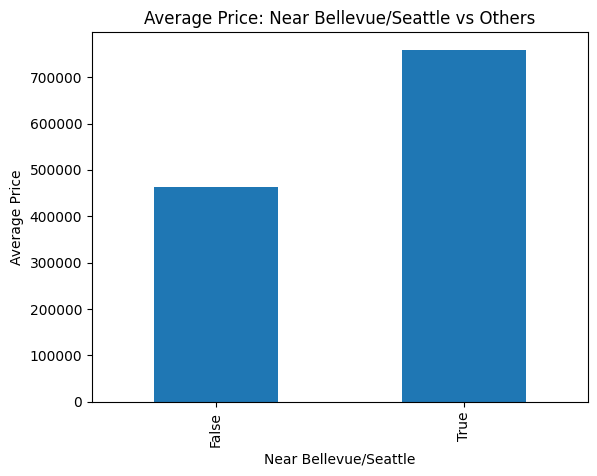

In [6]:
df.groupby('near_belv_seattle')['price'].mean().plot(kind='bar')
plt.title('Average Price: Near Bellevue/Seattle vs Others')
plt.xlabel('Near Bellevue/Seattle')
plt.ylabel('Average Price')
plt.show()

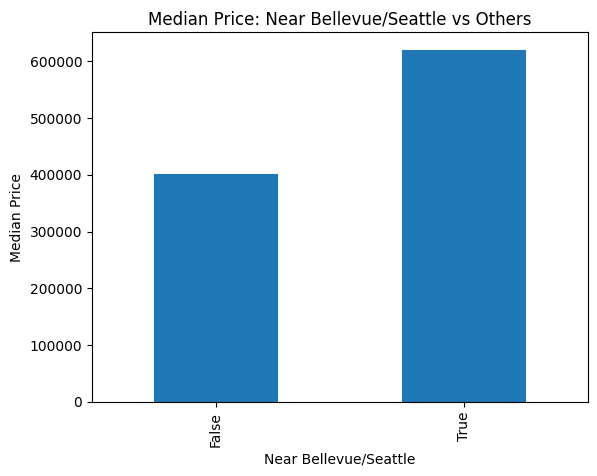

In [7]:
df.groupby('near_belv_seattle')['price'].median().plot(kind='bar')
plt.title('Median Price: Near Bellevue/Seattle vs Others')
plt.xlabel('Near Bellevue/Seattle')
plt.ylabel('Median Price')
plt.show()

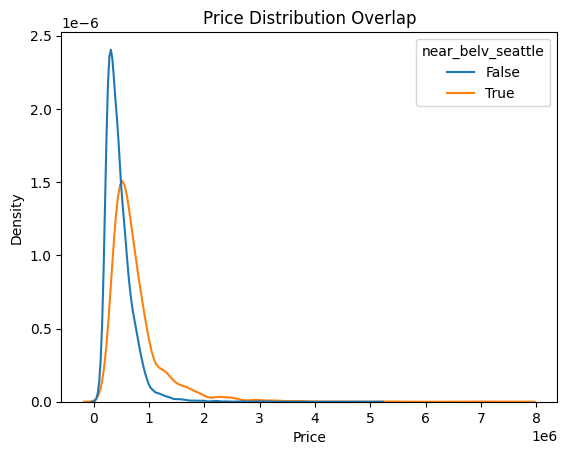

In [8]:
sns.kdeplot(data=df, x='price', hue='near_belv_seattle', common_norm=False)
plt.title('Price Distribution Overlap')
plt.xlabel('Price')
plt.show()

In [9]:
from scipy.stats import ttest_ind

# Split data
near = df[df['near_belv_seattle'] == True]['price']
not_near = df[df['near_belv_seattle'] == False]['price']

# Run Welch’s t-test (equal_var=False)
t_stat, p_value = ttest_ind(near, not_near, equal_var=False, alternative='greater')

print(f'T-statistic: {t_stat:.2f}')
print(f'P-value: {p_value:.4f}')

T-statistic: 41.84
P-value: 0.0000


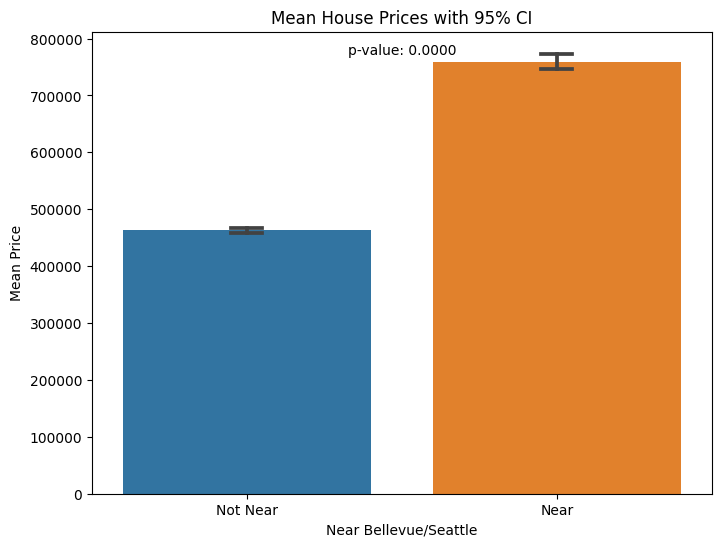

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: mean price barplot
plt.figure(figsize=(8, 6))
sns.barplot(x='near_belv_seattle', y='price', data=df, ci=95, capsize=0.1)

# Get the max visible y-axis limit instead of max(df['price']) 
ymax = plt.ylim()[1]  # this reads the current top of the y-axis

# Add p-value at the top
plt.text(x=0.5, y=ymax * 0.95, s=f'p-value: {p_value:.4f}', ha='center')

plt.title('Mean House Prices with 95% CI')
plt.xlabel('Near Bellevue/Seattle')
plt.ylabel('Mean Price')
plt.xticks([0, 1], ['Not Near', 'Near'])
plt.show()

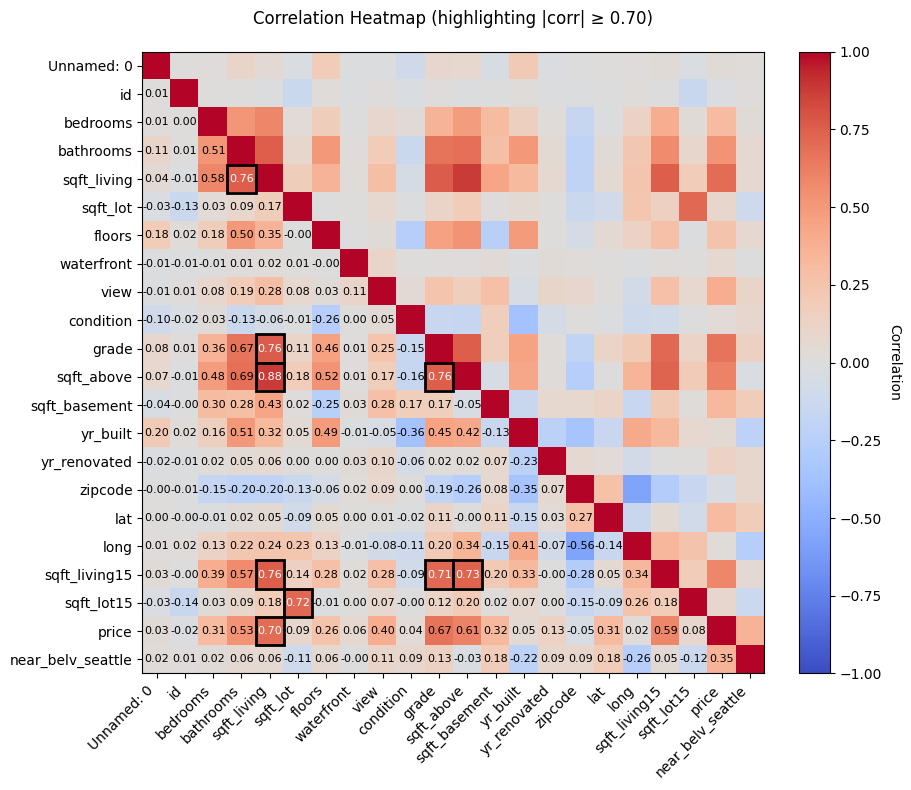

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1. Correlations (numeric cols only) ───────────────────────────────
corr = df.corr(numeric_only=True)

# ── 2. Triangular mask to hide duplicates ────────────────────────────
mask = np.triu(np.ones_like(corr, dtype=bool))

# ── 3. Plot base heatmap ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# ── 4. Annotate & highlight significant cells ───────────────────────
threshold = 0.70
for (i, j), value in np.ndenumerate(corr):
    if mask[i, j]:
        continue                     # skip upper triangle
    # numeric label
    ax.text(j, i, f'{value:.2f}',
            ha='center', va='center', fontsize=8,
            color='black' if abs(value) < threshold else 'white')
    # draw a box if |corr| >= 0.70
    if abs(value) >= threshold:
        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1,
                             fill=False, edgecolor='black', linewidth=2)
        ax.add_patch(rect)

# ── 5. Ticks & layout ────────────────────────────────────────────────
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Correlation', rotation=-90, va='bottom')
plt.title('Correlation Heatmap (highlighting |corr| ≥ 0.70)', pad=20)
plt.tight_layout()
plt.show()

## Second Hyphothesis
### Homes with bigger living spaces tend to cost more.

In [12]:
df_clean = df[
    (df['price'].between(df['price'].quantile(0.01), df['price'].quantile(0.99))) &
    (df['sqft_living'].between(df['sqft_living'].quantile(0.01), df['sqft_living'].quantile(0.99)))
]

<Axes: xlabel='price', ylabel='sqft_living'>

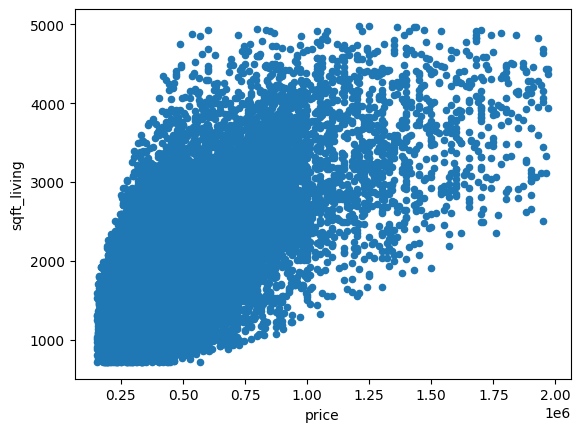

In [13]:
df_clean.plot(kind='scatter', x='price', y='sqft_living')

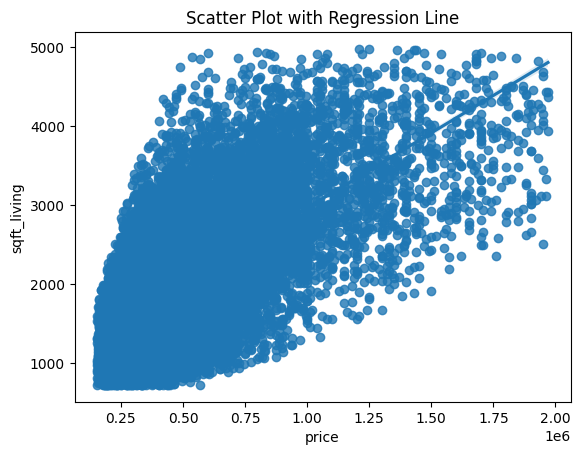

In [14]:
sns.regplot(data=df_clean, x='price', y='sqft_living')
plt.title('Scatter Plot with Regression Line')
plt.show()

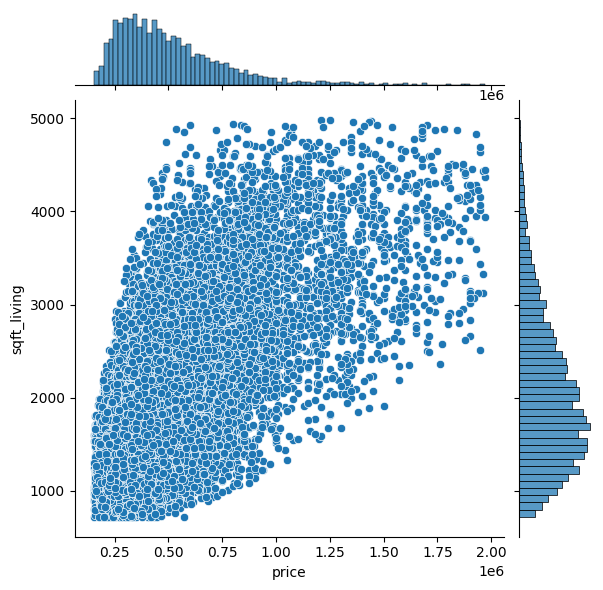

In [15]:
sns.jointplot(data=df_clean, x='price', y='sqft_living', kind='scatter')

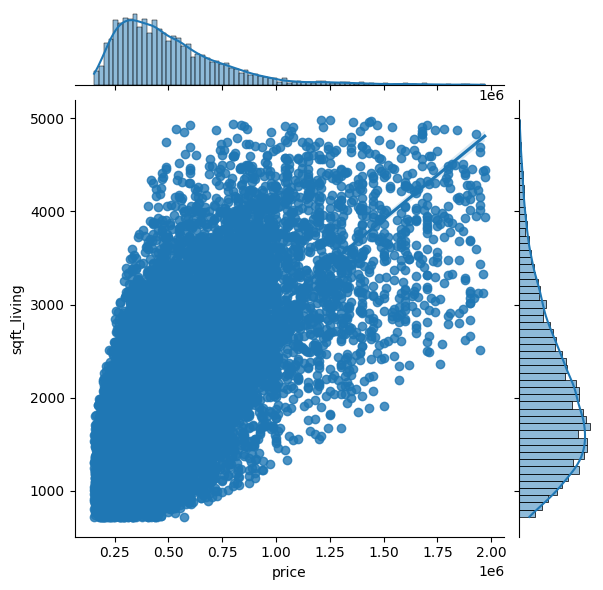

In [16]:
sns.jointplot(data=df_clean, x='price', y='sqft_living', kind='reg')

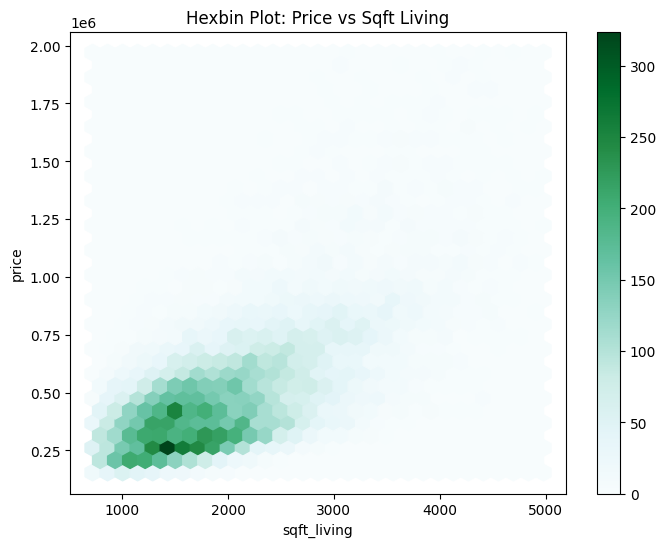

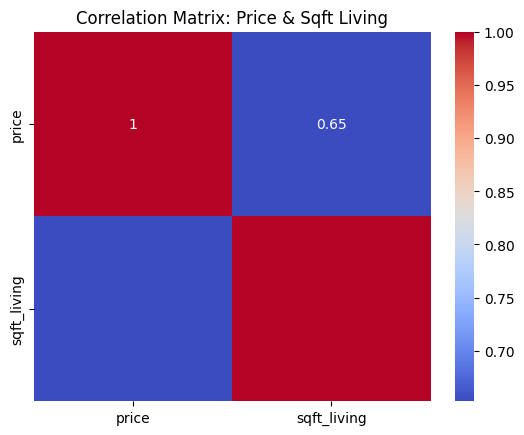

In [17]:

# 6️⃣ Hexbin - good for large data
df_clean.plot.hexbin(x='sqft_living', y='price', gridsize=30, figsize=(8, 6))
plt.title('Hexbin Plot: Price vs Sqft Living')
plt.show()

# 7️⃣ Correlation heatmap (if you want to see other pairs too)
corr = df_clean[['price', 'sqft_living']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Price & Sqft Living')
plt.show()

# 8️⃣ Pairplot (useful if adding more columns later)
# sns.pairplot(df[['price', 'sqft_living']])

Correlation: 0.65


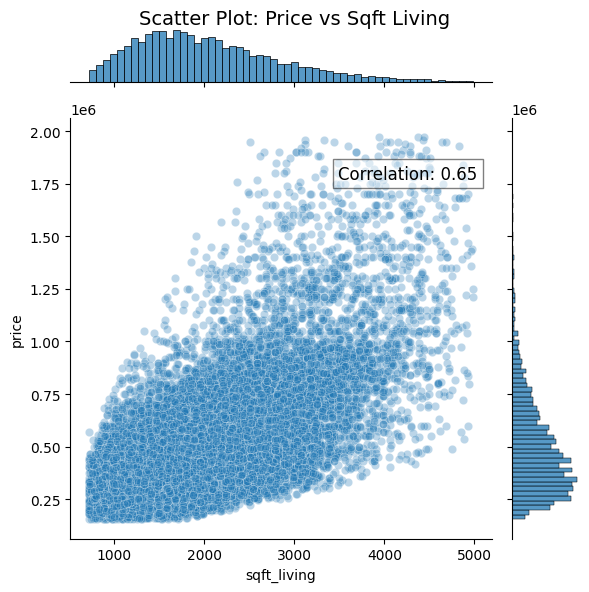

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation
corr = df_clean['price'].corr(df_clean['sqft_living'])
print(f"Correlation: {corr:.2f}")

# Make jointplot
g = sns.jointplot(data=df_clean, x='sqft_living', y='price', alpha=0.3)

# ✅ Add a global title ABOVE the plot
g.fig.suptitle('Scatter Plot: Price vs Sqft Living', fontsize=14)

# ✅ Adjust layout so title doesn't overlap the marginal axes
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)  # adjust as needed

# ✅ Add correlation annotation inside the main scatter area
x_pos = df_clean['sqft_living'].max() * 0.7
y_pos = df_clean['price'].max() * 0.9

g.ax_joint.text(x_pos, y_pos, f'Correlation: {corr:.2f}',
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5))

plt.show()

## Third Hyphothesis
### Homes with waterfront usually sell for higher prices.

In [21]:
def cat_cat_correlation(df_,cat_col1,cat_col2):
    """
    This function spits out Cramer's correlation statistic, with Bergsma-Wicher 
    correction, between two categorical columns of a dataframe 
    """
    crosstab = pd.crosstab(df_[cat_col1], df_[cat_col2])
    chi_sqr = stats.chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    r,k = crosstab.shape
    phi_sqr_corr = max(0, chi_sqr/n - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    
    result = np.sqrt(phi_sqr_corr / min( (k_corr-1), (r_corr-1)))
    return round(result,3)

In [22]:
def cat_num_correlation(df_,cat_col,num_col):
    """
    This function spits out a sensible correlation coefficient
    between a categorical column and a numerical column of a dataframe.
    The correlation is essentially the corrected Cramer's correlation statistic,
    after the numerical data points have been transformed under optimal binning
    """
    _df = df_.copy()
    class_number = _df[cat_col].nunique()
    binning = op.MulticlassOptimalBinning()
    _df['binned_feature'] =binning.fit_transform(_df[num_col], _df[cat_col])
    result = cat_cat_correlation(_df,cat_col,'binned_feature')
    return round(result,3)

In [48]:
cat_num_correlation(df_clean,'waterfront','price')
cat_col = 'waterfront'
num_col = 'price'


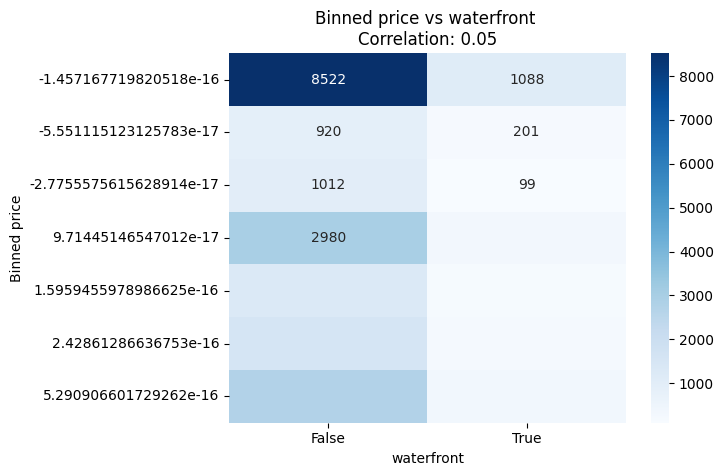

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copy and get binned version
_df = df.copy()
binning = op.MulticlassOptimalBinning()
_df['binned_feature'] = binning.fit_transform(_df[num_col], _df[cat_col])

# Make a crosstab
ct = pd.crosstab(_df['binned_feature'], _df[cat_col])

# Plot heatmap of counts
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title(f'Binned {num_col} vs {cat_col} \nCorrelation: {cat_num_correlation(df, cat_col, num_col)}')
plt.ylabel(f'Binned {num_col}')
plt.xlabel(cat_col)
plt.show()

waterfront     False  True 
_binned_label              
$78K–$225K     19060   2537


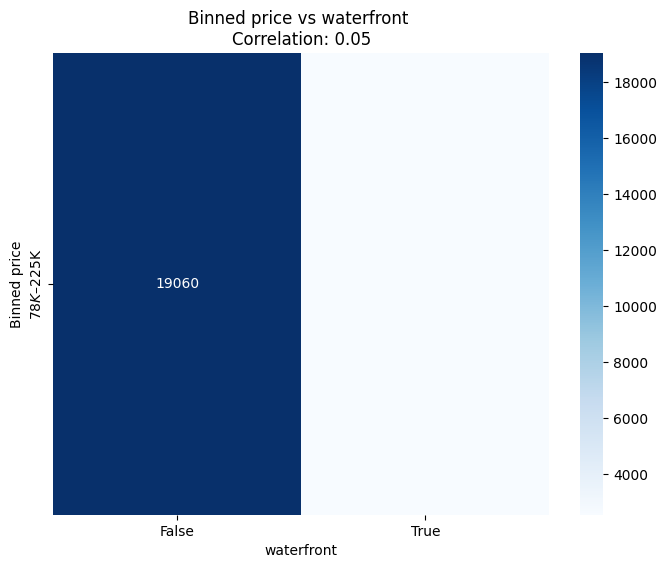

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from optbinning import MulticlassOptimalBinning  # only if you really want it

def cat_num_correlation_visual(df, cat_col, num_col, bins=5):
    """
    Compute correlation between categorical & numerical columns using binning.
    Show a heatmap of the crosstab with clear bin labels.
    Falls back to qcut if optbinning fails.
    """

    _df = df.copy()

    ### --- TRY optbinning ---
    try:
        binning = MulticlassOptimalBinning()
        _df['_binned'] = binning.fit_transform(_df[num_col], _df[cat_col])
        # If all NaN, fallback
        if _df['_binned'].isna().all():
            raise ValueError('Optbinning returned all NaN.')
    except Exception as e:
        print(f"[INFO] Optbinning failed, falling back to pd.qcut: {e}")
        _df['_binned'] = pd.qcut(_df[num_col], q=bins, duplicates='drop', labels=False)

    ### --- Build readable bin labels ---
    # If using qcut: get bin edges
    if '_binned' in _df:
        if hasattr(binning, 'splits'):
            # If splits exist: get edges
            splits = list(binning.splits) if hasattr(binning, 'splits') else []
            edges = [df[num_col].min()] + splits + [df[num_col].max()]
        else:
            # For qcut, pd.cut, rebuild edges manually
            _, edges = pd.qcut(_df[num_col], q=bins, retbins=True, duplicates='drop')

        # Make label for each bin number
        bin_labels = []
        for i in range(len(edges) - 1):
            left = int(edges[i])
            right = int(edges[i+1])
            label = f"${left//1000}K–${right//1000}K"
            bin_labels.append(label)

        # Map bin numbers to labels
        _df['_binned_label'] = _df['_binned'].map(lambda x: bin_labels[int(x)] if pd.notnull(x) else np.nan)

    ### --- Build crosstab ---
    ct = pd.crosstab(_df['_binned_label'], _df[cat_col])
    print(ct.head())

    if ct.empty:
        print("Crosstab is empty — check your input or binning.")
        return

    ### --- Compute correlation for info ---
    corr_value = round(cat_num_correlation(df, cat_col, num_col), 3)

    ### --- Plot ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Binned {num_col} vs {cat_col} \nCorrelation: {corr_value}')
    plt.ylabel(f'Binned {num_col}')
    plt.xlabel(cat_col)
    plt.show()

# Example usage
cat_num_correlation_visual(df, 'waterfront', 'price', bins=5)

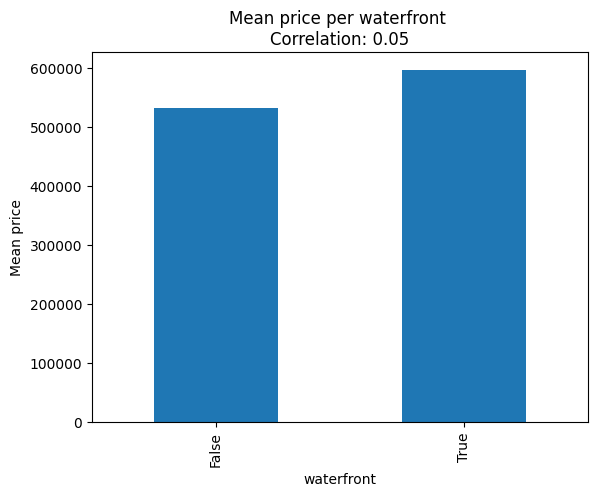

In [50]:
df.groupby(cat_col)[num_col].mean().plot(kind='bar')
plt.title(f'Mean {num_col} per {cat_col} \nCorrelation: {cat_num_correlation(df, cat_col, num_col)}')
plt.ylabel(f'Mean {num_col}')
plt.xlabel(cat_col)
plt.show()

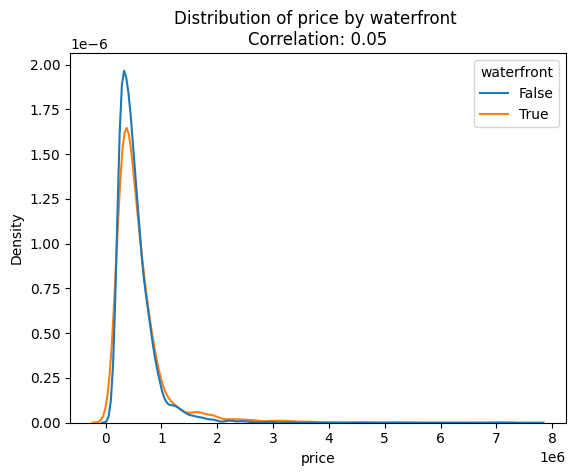

In [51]:
sns.kdeplot(data=df, x=num_col, hue=cat_col, common_norm=False)
plt.title(f'Distribution of {num_col} by {cat_col} \nCorrelation: {cat_num_correlation(df, cat_col, num_col)}')
plt.show()

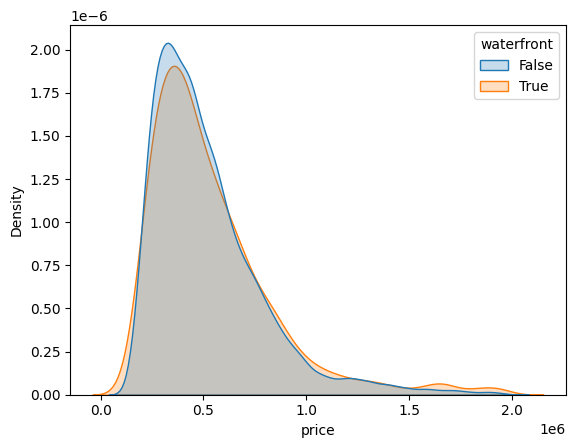

In [61]:
sns.kdeplot(data=df_clean, x='price', hue='waterfront', fill= True,common_norm=False );

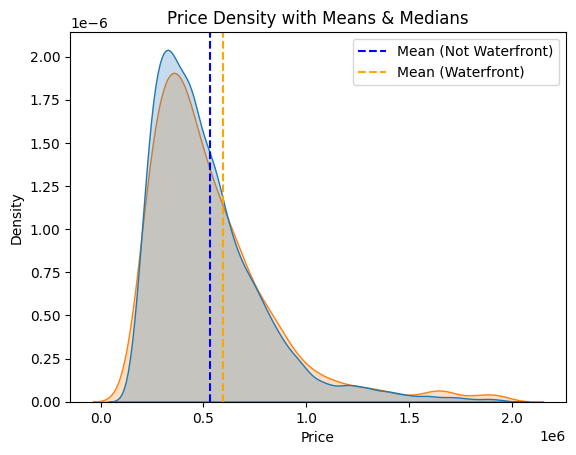

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Basic KDE with hue
sns.kdeplot(data=df_clean, x='price', hue='waterfront', fill=True, common_norm=False)

# Calculate mean & median for each group
mean_no = df[df['waterfront'] == False]['price'].mean()
# median_no = df[df['waterfront'] == False]['price'].median()

mean_yes = df[df['waterfront'] == True]['price'].mean()
# median_yes = df[df['waterfront'] == True]['price'].median()

# Add vertical lines
plt.axvline(mean_no, color='blue', linestyle='--', label='Mean (Not Waterfront)')
# plt.axvline(median_no, color='blue', linestyle=':', label='Median (Not Waterfront)')

plt.axvline(mean_yes, color='orange', linestyle='--', label='Mean (Waterfront)')
# plt.axvline(median_yes, color='orange', linestyle=':', label='Median (Waterfront)')

plt.title('Price Density with Means & Medians')
plt.xlabel('Price')
plt.legend()
plt.show()

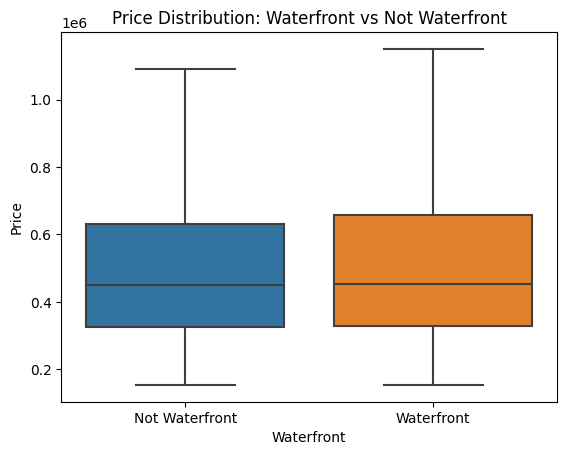

In [45]:
sns.boxplot(data=df_clean, x='waterfront', y='price', showfliers=False)
plt.title('Price Distribution: Waterfront vs Not Waterfront')
plt.xlabel('Waterfront')
plt.ylabel('Price')
plt.xticks([0, 1], ['Not Waterfront', 'Waterfront'])
plt.show()

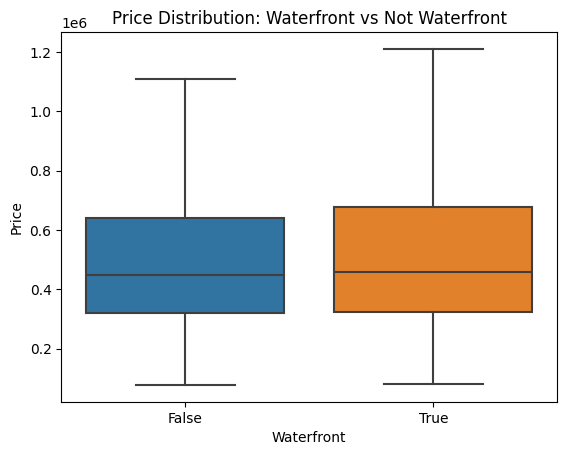

In [46]:
sns.boxplot(x='waterfront', y='price', data=df, showfliers=False)
plt.title('Price Distribution: Waterfront vs Not Waterfront')
plt.xlabel('Waterfront')
plt.ylabel('Price')
plt.show()